<img src="./logo_UNSAM.jpg" align="right" width="150" />  

#### Análisis y Porcesamiento de Señales

# Trabajo Práctico Nº3
#### Catalina Re


En el presente trabajo se simuló el comportamiento del ADC al digitalizar una señal senoidal contaminada con ruido. Los parametros que se ajustaron fueron:
- frecuencia $f_0$
- energía normalizada

Y para el ruido los parámetros fueron:
- señal que entra al ADC $s_R=s+n$, siendo $s$ la senoidal y $n$ la secuencia de ruido
- la potencia del ruido $P_n=k_nP_q$ siendo $k_n$ una escala para la potenia del ruido de cuantización $P_q=\frac{q^2}{12}$
- $n$ será incorrelado (el valor del ruido en un instante de tiempo no depende del valor en otro instante) y gaussiano (los valores del ruido siguen una distribución normal)

Se realizaron 4 mediciones:
- $B=4 bits$ y $k_n=1$
- $B=4 bits$ y $k_n=\frac{1}{10}$
- $B=8 bits$ y $k_n=1$
- $B=16 bits$ y $k_n=10$

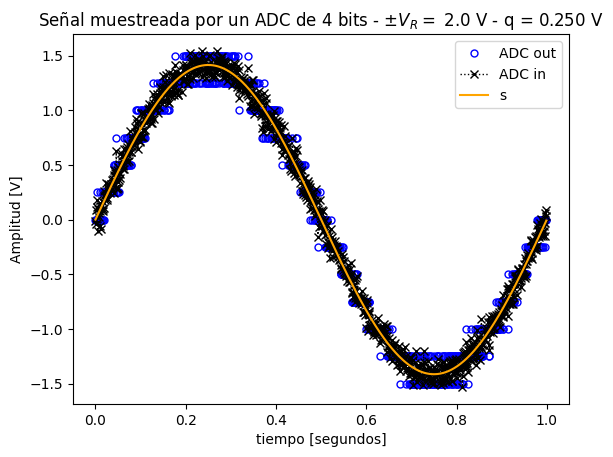

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

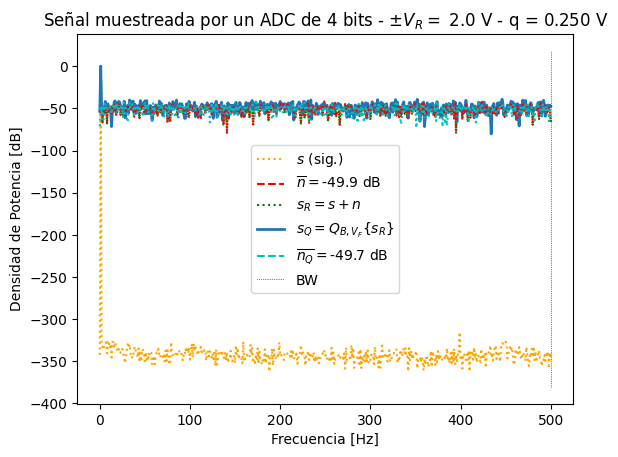

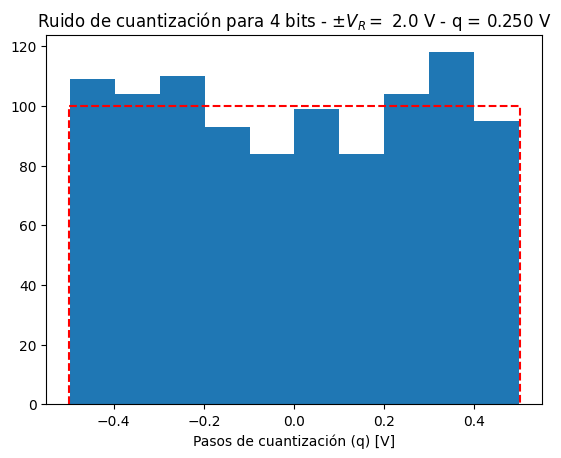

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#defino la funcion para la señal senoidal
def mi_funcion_sen (vmax, dc, ff, ph, N, fs):
    #fs frecuencia de muestreo (Hz)
    #N cantidad de muestras
    
    ts = 1/fs # tiempo de muestreo o periodo
    tt=np.linspace (0, (N-1)*ts, N) #vector de tiempo
    
    #generacion de la señal senoidal
    xx= dc + vmax*np.sin(2*np.pi*ff*tt + ph)
    #la señal debe generarse con la formula: x(t)=DC+Vmax*sen(2pift+fase)
    
    return tt, xx

#%%Señal senoidal

#genero la señal
tt, xx = mi_funcion_sen(1.4, 0, 1, 0, 1000, 1000)

#normalizar para que la potencia sea 1 con desvío estándar
xn=xx/np.std(xx) #pasa a ser la señal normalizada

#%%Ruido

fs =  1000 # frecuencia de muestreo (Hz)
N =  1000 # cantidad de muestras
# con 1000 para cada una normalizamos la resolucion espectral

# Datos del ADC ruido digital
B =  4 # bits (los elegimos entre todos)
Vf = 2 # rango simétrico de +/- Vf Volts (Al graficar, para que la funcion se vea bien y no toque los bordes)
q = Vf/(2**(B-1)) # paso de cuantización de q Volts (q=Vf/2^B-1)

# datos del ruido (potencia de la señal normalizada, es decir 1 W)
pot_ruido_cuant =  q**2/12 # Watts 
kn = 1. # escala de la potencia de ruido analógico
pot_ruido_analog = pot_ruido_cuant * kn

ts =  1/fs # tiempo de muestreo
df =  fs/N # resolución espectral

#generacion de la señal de ruido
nn = np.random.normal(0, np.sqrt(pot_ruido_analog), N) # señal de ruido de analógico

#%%Señal analogica

sr = xn + nn # señal analógica de entrada al ADC (con ruido analógico)

srq = np.round(sr/q)*q # señal cuantizada
nq =  srq - sr# señal de ruido de cuantización

#%%Gráficos

#B=4 k=1
#señal temporal
plt.figure(1)

plt.plot(tt, srq, lw=2, linestyle='', color='blue', marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='blue', fillstyle='none', label='ADC out')
plt.plot(tt, sr, lw=1, color='black', marker='x', ls='dotted', label='ADC in')
plt.plot(tt, xn, color='orange', label='s')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

#espectro
plt.figure(2)
ft_SR = 1/N*np.fft.fft( sr)
ft_Srq = 1/N*np.fft.fft( srq)
ft_xn = 1/N*np.fft.fft( xn)
ft_Nq = 1/N*np.fft.fft( nq)
ft_Nn = 1/N*np.fft.fft( nn)

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)

bfrec = ff <= fs/2 

Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_xn[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn[bfrec])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()

#histograma
plt.figure(3)
bins = 10
plt.hist(nq.flatten()/(q), bins=bins)
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.xlabel('Pasos de cuantización (q) [V]')

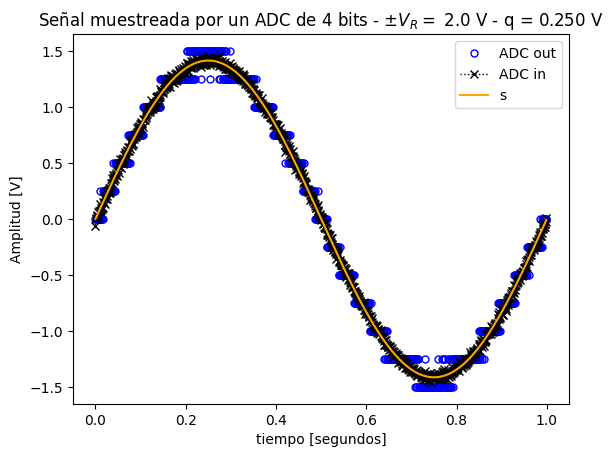

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

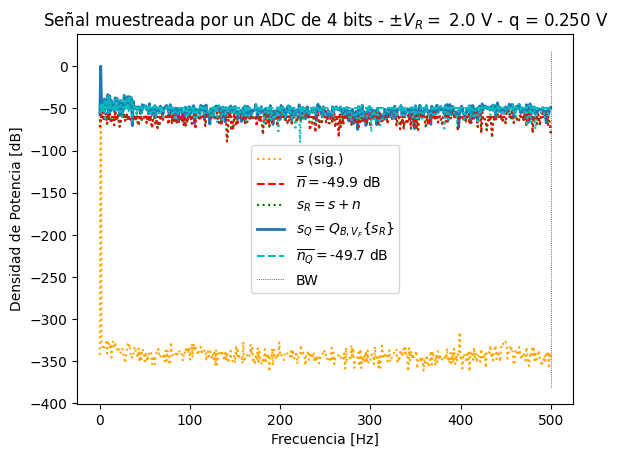

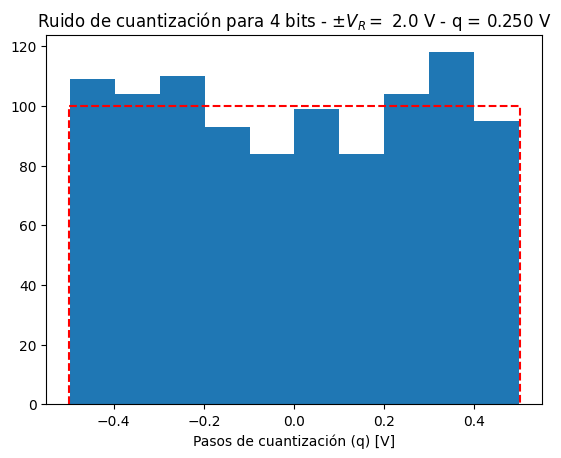

In [2]:
#%%B=4 k=1/10
#k0=1/10 

B0 =  4 # bits (los elegimos entre todos)
Vf0 = 2 # rango simétrico de +/- Vf Volts (Al graficar, para que la funcion se vea bien y no toque los bordes)
q0 = Vf0/(2**(B0-1)) # paso de cuantización de q Volts (q=Vf/2^B-1)

# datos del ruido (potencia de la señal normalizada, es decir 1 W)
pot_ruido_cuant0 =  q0**2/12 # Watts 
kn0 = 1/10. # escala de la potencia de ruido analógico
pot_ruido_analog0 = pot_ruido_cuant0 * kn0

ts =  1/fs # tiempo de muestreo
df =  fs/N # resolución espectral

#generacion de la señal de ruido
nn0 = np.random.normal(0, np.sqrt(pot_ruido_analog0), N) # señal de ruido de analógico

#señal analógica
sr0 = xn + nn0 # señal analógica de entrada al ADC (con ruido analógico)

srq0 = np.round(sr0/q0)*q0 # señal cuantizada
nq0 =  srq0 - sr0# señal de ruido de cuantización

#Gráficos
#señal temporal
plt.figure(4)

plt.plot(tt, srq0, lw=2, linestyle='', color='blue', marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='blue', fillstyle='none', label='ADC out')
plt.plot(tt, sr0, lw=1, color='black', marker='x', ls='dotted', label='ADC in')
plt.plot(tt, xn, color='orange', label='s')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B0, Vf0, q0) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

#espectro
plt.figure(5)
ft_SR0 = 1/N*np.fft.fft( sr0)
ft_Srq0 = 1/N*np.fft.fft( srq0)
ft_xn0 = 1/N*np.fft.fft( xn)
ft_Nq0 = 1/N*np.fft.fft( nq0)
ft_Nn0 = 1/N*np.fft.fft( nn0)

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)

bfrec = ff <= fs/2 

Nnq_mean0 = np.mean(np.abs(ft_Nq0)**2)
nNn_mean0 = np.mean(np.abs(ft_Nn0)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_xn0[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean0, nNn_mean0]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR0[bfrec])**2), ':g', label='$ s_R = s + n $' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq0[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean0, Nnq_mean0]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn0[bfrec])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq0[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B0, Vf0, q0) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()

#histograma
plt.figure(6)
bins = 10
plt.hist(nq.flatten()/(q0), bins=bins)
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B0, Vf0, q0))
plt.xlabel('Pasos de cuantización (q) [V]')

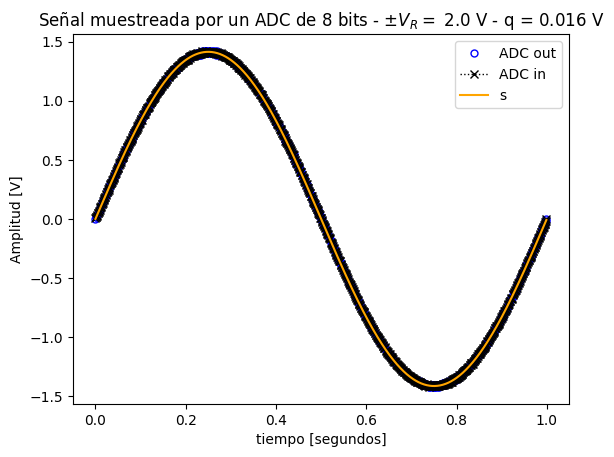

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

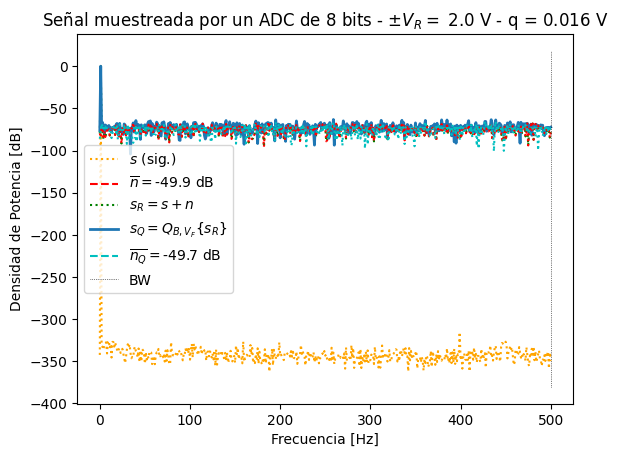

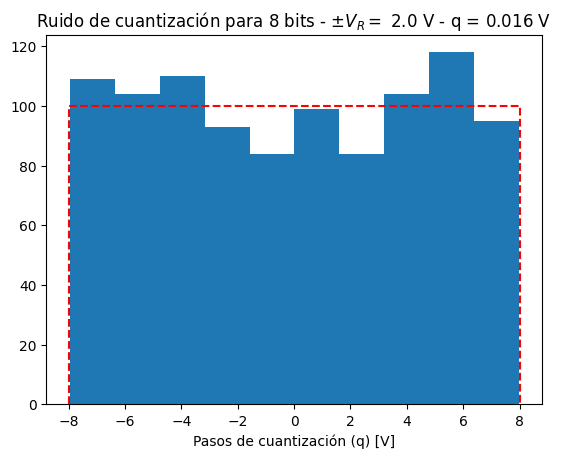

In [3]:
#%%B=8 k=1
B1 =  8 # bits (los elegimos entre todos)
Vf1 = 2 # rango simétrico de +/- Vf Volts (Al graficar, para que la funcion se vea bien y no toque los bordes)
q1 = Vf1/(2**(B1-1)) # paso de cuantización de q Volts (q=Vf/2^B-1)

# datos del ruido (potencia de la señal normalizada, es decir 1 W)
pot_ruido_cuant1 =  q1**2/12 # Watts 
kn1 = 1 # escala de la potencia de ruido analógico
pot_ruido_analog1 = pot_ruido_cuant1 * kn1

ts =  1/fs # tiempo de muestreo
df =  fs/N # resolución espectral

#generacion de la señal de ruido
nn1 = np.random.normal(0, np.sqrt(pot_ruido_analog1), N) # señal de ruido de analógico

#señal analógica
sr1 = xn + nn1 # señal analógica de entrada al ADC (con ruido analógico)

srq1 = np.round(sr1/q1)*q1 # señal cuantizada
nq1 =  srq1 - sr1# señal de ruido de cuantización

#Gráficos
#señal temporal
plt.figure(7)

plt.plot(tt, srq1, lw=2, linestyle='', color='blue', marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='blue', fillstyle='none', label='ADC out')
plt.plot(tt, sr1, lw=1, color='black', marker='x', ls='dotted', label='ADC in')
plt.plot(tt, xn, color='orange', label='s')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B1, Vf1, q1) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

#espectro
plt.figure(8)
ft_SR1 = 1/N*np.fft.fft( sr1)
ft_Srq1 = 1/N*np.fft.fft( srq1)
ft_xn1 = 1/N*np.fft.fft( xn)
ft_Nq1 = 1/N*np.fft.fft( nq1)
ft_Nn1 = 1/N*np.fft.fft( nn1)

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)

bfrec = ff <= fs/2 

Nnq_mean1 = np.mean(np.abs(ft_Nq1)**2)
nNn_mean1 = np.mean(np.abs(ft_Nn1)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_xn1[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean1, nNn_mean1]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR1[bfrec])**2), ':g', label='$ s_R = s + n $' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq1[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean1, Nnq_mean1]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn1[bfrec])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq1[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B1, Vf1, q1) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()

#histograma
plt.figure(9)
bins = 10
plt.hist(nq.flatten()/(q1), bins=bins)
plt.plot( np.array([-8, -8, 8, 8]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B1, Vf1, q1))

plt.xlabel('Pasos de cuantización (q) [V]')

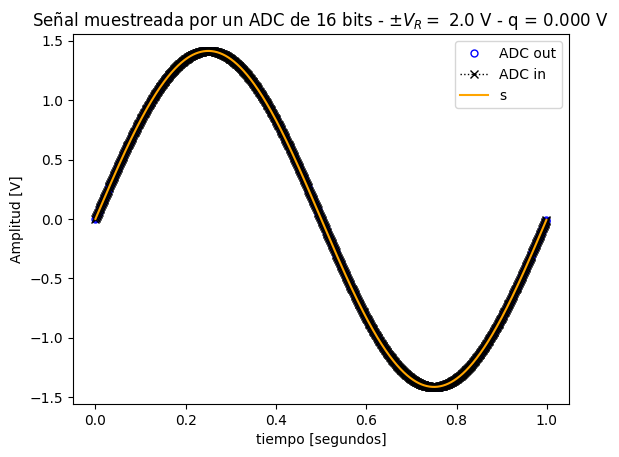

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

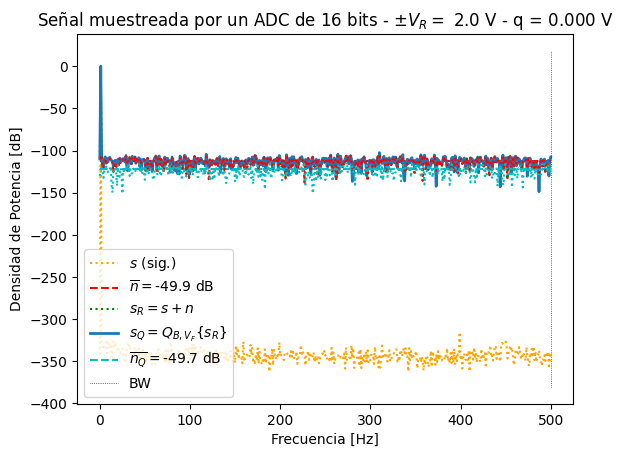

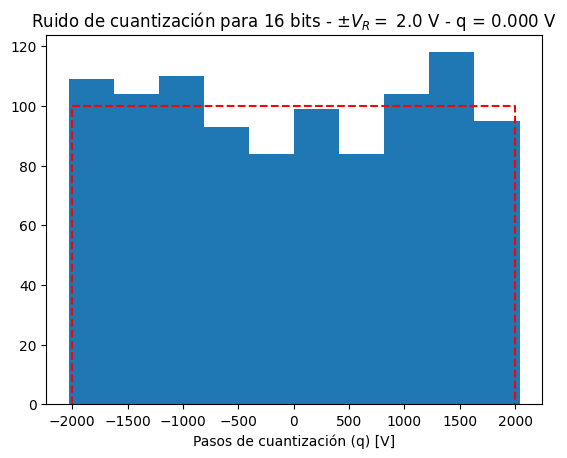

In [4]:
#%%B=16 k=10
B2 =  16 # bits (los elegimos entre todos)
Vf2 = 2 # rango simétrico de +/- Vf Volts (Al graficar, para que la funcion se vea bien y no toque los bordes)
q2 = Vf2/(2**(B2-1)) # paso de cuantización de q Volts (q=Vf/2^B-1)

# datos del ruido (potencia de la señal normalizada, es decir 1 W)
pot_ruido_cuant2 =  q2**2/12 # Watts 
kn2 = 10 # escala de la potencia de ruido analógico
pot_ruido_analog2 = pot_ruido_cuant2 * kn2

ts =  1/fs # tiempo de muestreo
df =  fs/N # resolución espectral

#generacion de la señal de ruido
nn2 = np.random.normal(0, np.sqrt(pot_ruido_analog2), N) # señal de ruido de analógico

#señal analógica
sr2 = xn + nn2 # señal analógica de entrada al ADC (con ruido analógico)

srq2 = np.round(sr2/q2)*q2 # señal cuantizada
nq2 =  srq2 - sr2# señal de ruido de cuantización

#Gráficos
#señal temporal
plt.figure(10)

plt.plot(tt, srq2, lw=2, linestyle='', color='blue', marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='blue', fillstyle='none', label='ADC out')
plt.plot(tt, sr2, lw=1, color='black', marker='x', ls='dotted', label='ADC in')
plt.plot(tt, xn, color='orange', label='s')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B2, Vf2, q2) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

#espectro
plt.figure(11)
ft_SR2 = 1/N*np.fft.fft( sr2)
ft_Srq2 = 1/N*np.fft.fft( srq2)
ft_xn2 = 1/N*np.fft.fft( xn)
ft_Nq2 = 1/N*np.fft.fft( nq2)
ft_Nn2 = 1/N*np.fft.fft( nn2)

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)

bfrec = ff <= fs/2 

Nnq_mean2 = np.mean(np.abs(ft_Nq2)**2)
nNn_mean2 = np.mean(np.abs(ft_Nn2)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_xn2[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean2, nNn_mean2]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR2[bfrec])**2), ':g', label='$ s_R = s + n $' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq2[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean2, Nnq_mean2]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn2[bfrec])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq2[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B2, Vf2, q2) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()

#histograma
plt.figure(12)
bins = 10
plt.hist(nq.flatten()/(q2), bins=bins)
plt.plot( np.array([-2000, -2000, 2000, 2000]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B2, Vf2, q2))

plt.xlabel('Pasos de cuantización (q) [V]')

A partir del análisis de los gráficos de la señal temporal, del espectro y del histograma se puede concluir que el ruido de cuantización es más relevante cuando el ruido la potencia de ruido analógico es baja respecto a la señal. Cuando se aumenta la cantidad de bits del ADC, se produce una mejor resolución y disminuye el ruido de cuantización. Los histogramas del ruido de cuantización muestran que para pocos bits el mismo tiene una forma rectangular (uniforme entre $\frac{-q}{2}$ y $\frac{q}{2}$. Y para muchos bits, el ruido de cuantización es mucho más concentrado cerca de 0 (porque $q$ es muy pequeño). 